<a href="https://colab.research.google.com/github/Naman-Kapoor26/BALL-BEARING-FAULT-DETECTION/blob/main/Fault_Detection_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Naman-Kapoor26/BALL-BEARING-FAULT-DETECTION.git

Cloning into 'BALL-BEARING-FAULT-DETECTION'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 99 (delta 7), reused 0 (delta 0), pack-reused 61
Unpacking objects: 100% (99/99), 91.55 MiB | 8.15 MiB/s, done.
Updating files: 100% (65/65), done.


In [ ]:
import os
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
from sklearn.metrics import confusion_matrix
import tensorflow as tf


In [ ]:
subdir_path = '/content/BALL-BEARING-FAULT-DETECTION/Labelled Images' 

In [ ]:
fault_type=[]
for file_name in os.listdir(subdir_path):
  file_path=subdir_path+'/'+file_name
  if file_path.endswith('.npy'):
    fault_type.append(file_name[:-4])

In [ ]:
imgs=[]
imgs_label=[]
for file_name in os.listdir(subdir_path):
  file_path=subdir_path+'/'+file_name
  if file_path.endswith('.npy'):
    image_bunch=np.load(file_path)
    for i in range(len(image_bunch)):
      imgs.append(image_bunch[i]) #images
      imgs_label.append(fault_type.index(file_name[:-4])) #encoding fault_labels



In [ ]:
X=np.array(imgs)
y=np.array(imgs_label)
X = np.stack((X,) * 3, axis=-1)
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2,shuffle=True, random_state=42)

 ResNet18 is a relatively small and efficient model compared to other deep learning architectures, which makes it well-suited for datasets with limited samples. <br>
In the case of the CWRU ball bearing dataset, which contains around 2900 images, ResNet18 is a good choice because it can be trained relatively quickly and with lower computational resources compared to larger models.


In [ ]:
class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
            self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()


    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):
  def __init__(self, num_classes, **kwargs):
    super().__init__(**kwargs)
    self.conv_1 = Conv2D(64, (7, 7), strides=2,padding="same", kernel_initializer="he_normal")
    self.init_bn = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
    self.res_1_1 = ResnetBlock(64)
    self.res_1_2 = ResnetBlock(64)
    self.res_2_1 = ResnetBlock(128, down_sample=True)
    self.res_2_2 = ResnetBlock(128)
    self.res_3_1 = ResnetBlock(256, down_sample=True)
    self.res_3_2 = ResnetBlock(256)
    self.res_4_1 = ResnetBlock(512, down_sample=True)
    self.res_4_2 = ResnetBlock(512)
    self.avg_pool = GlobalAveragePooling2D()
    self.flat = Flatten()
    self.fc = Dense(num_classes, activation="softmax")

      
  def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out    


In [ ]:
model = ResNet18(10)
model.build(input_shape = (None,64,64,3))
from keras.optimizers import SGD
opt=SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04)
model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)
model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 resnet_block (ResnetBlock)  multiple                  74368     
                                                                 
 resnet_block_1 (ResnetBlock  multiple              

In [20]:
from keras.callbacks import EarlyStopping

history = model.fit(train_data,train_labels, batch_size=32, epochs=1)

73/73 [==============================] - 105s 1s/step - loss: 0.0012 - accuracy: 1.0000


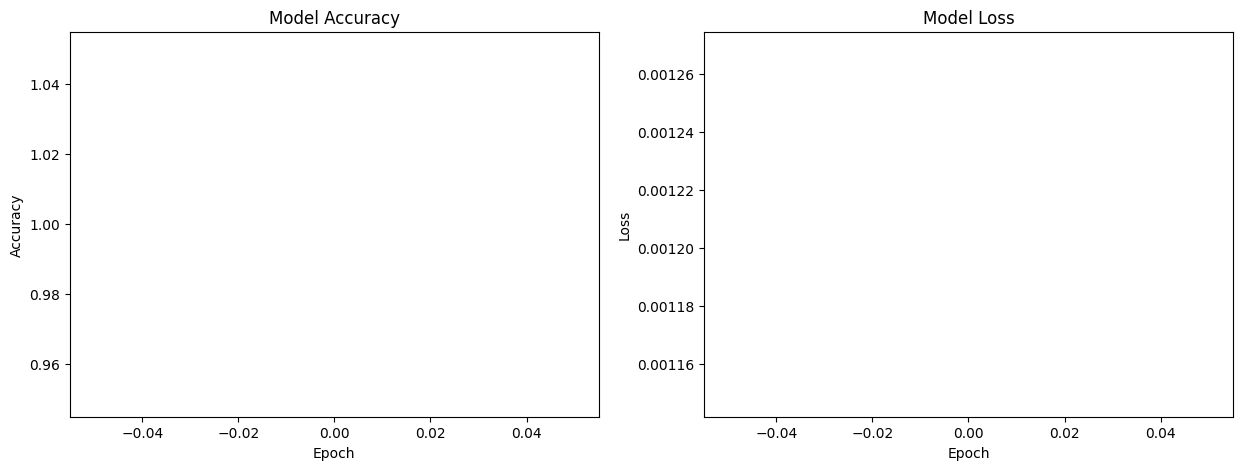

In [21]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    plt.show()
    
plotmodelhistory(history)

In [22]:
model.predict(test_data)

19/19 [==============================] - 4s 186ms/step


array([[2.2792915e-10, 2.1514155e-07, 5.5554624e-06, ..., 2.9251771e-07,
        1.7854531e-07, 3.0967433e-06],
       [0.0000000e+00, 0.0000000e+00, 9.9999994e-01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.3275916e-09, 9.8891662e-10, 3.1581775e-09, ..., 9.9999624e-01,
        4.4078108e-10, 2.2034936e-09],
       ...,
       [0.0000000e+00, 0.0000000e+00, 9.9999994e-01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 9.9999994e-01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.9268200e-04, 4.4579970e-04, 2.8392222e-05, ..., 1.3628315e-08,
        4.3981901e-05, 2.6912224e-07]], dtype=float32)

In [23]:
trainPredictions=model.predict(train_data)
testPredictions=model.predict(test_data)

testy_pred=[]
for i in testPredictions:
  testy_pred.append(np.argmax(i))

trainy_pred=[]
for i in trainPredictions:
  trainy_pred.append(np.argmax(i))


19/19 [==============================] - 4s 206ms/step


In [26]:
print(testy_pred[0:10])
test_labels[0:10]

[6, 2, 7, 6, 4, 0, 7, 1, 8, 7]


array([6, 2, 7, 6, 4, 0, 7, 1, 8, 7])

In [27]:
test_confu_matrix = confusion_matrix(test_labels,testy_pred)
train_confu_matrix = confusion_matrix(train_labels,trainy_pred)

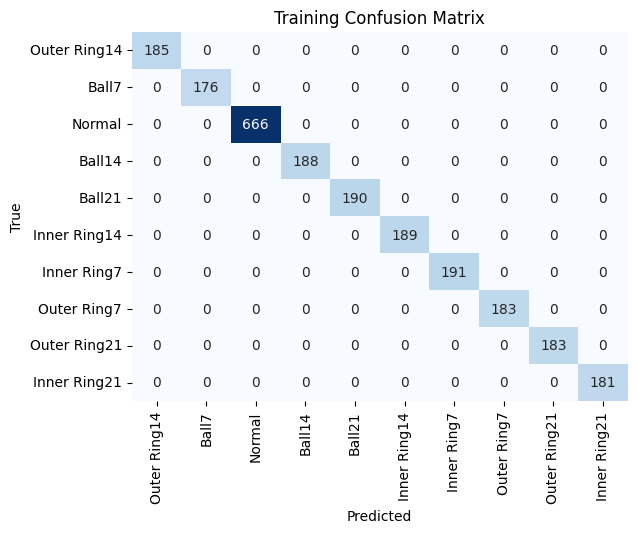

In [28]:
sns.heatmap(train_confu_matrix, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Exception ignored in: <function _xla_gc_callback at 0x7f758bca9d80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


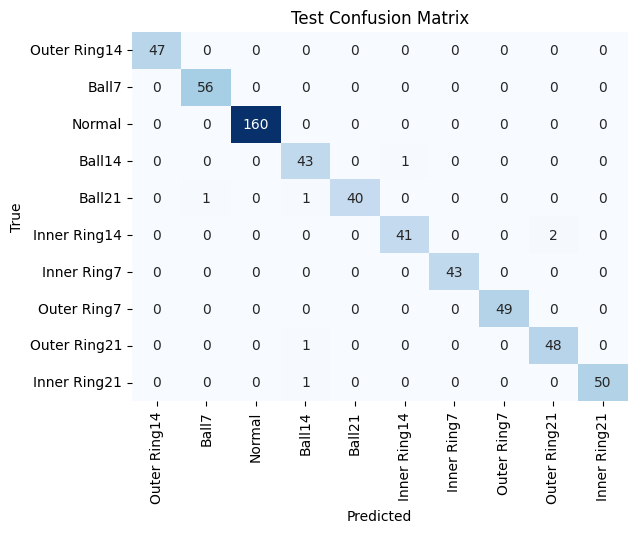

In [29]:

sns.heatmap(test_confu_matrix, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
     

In [30]:
model.evaluate(train_data, train_labels)

73/73 [==============================] - 15s 208ms/step - loss: 7.3865e-04 - accuracy: 1.0000


[0.0007386544020846486, 1.0]

In [31]:
model.evaluate(test_data, test_labels)

19/19 [==============================] - 3s 138ms/step - loss: 0.0262 - accuracy: 0.9880


[0.026208514347672462, 0.9880136847496033]

NotImplementedError: ignored